In [1]:
import pandas as pd
from glob import glob
import os
import seaborn as sns
import re
from matplotlib import pyplot as plt

In [2]:
INCLUDE_SWIFT_LONG_LIBS = False

In [3]:
fastqc_results = glob("01_data_qc/QualityControl/*_001_fastqc/fastqc_data.txt")

In [4]:
def get_fastqc_data(path):
    name, suffixes = os.path.basename(os.path.dirname(path)).split("_", maxsplit=1)
    if 'Swift-long' in name:
        ide, _, _, conc, repl = name.split("-")
        kit = "Swiftlong"
        if not INCLUDE_SWIFT_LONG_LIBS:
            return []
    else:
        ide, kit, conc, repl = name.split("-")
    read = int(re.search(r"_R([12])_", suffixes).group(1))
    row_const = {'Kit': kit, 'Conc': conc, 'Replicate': repl, 'Read': read}
    section = 0
    rows = []
    with open(path) as f:
        for line in f:
            if section == 0:
                if line.startswith(">>Per base sequence content"):
                    section = 1
            elif section == 1:
                section += 1
            else:
                if line.startswith(">>END_MODULE"):
                    return rows
                else:
                    parts = line.strip().split()
                    if "-" in parts[0]:
                        pos, end = [int(x) for x in parts[0].split("-")]
                    else:
                        pos = end = int(parts[0])
                    for nucleotide, percent in zip("GATC", parts[1:]):
                        row = {"Pos": pos, "end": end, "Nucleotide": nucleotide, "Percent": float(percent)}
                        row.update(row_const)
                        rows.append(row)
    return []
                
            

In [5]:
df = pd.DataFrame([k for ks in map(get_fastqc_data, fastqc_results) for k in ks])
df.Conc = pd.Categorical(df.Conc, categories=['10ng', '100ng'])
if INCLUDE_SWIFT_LONG_LIBS:
    df.Kit = pd.Categorical(df.Kit, categories=['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'])
else:
    df.Kit = pd.Categorical(df.Kit, categories=['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S'])

In [6]:
df.head()

,Pos,end,Nucleotide,Percent,Kit,Conc,Replicate,Read
0,1,1,G,26.443208,Kapa,100ng,4,2
1,1,1,A,21.347386,Kapa,100ng,4,2
2,1,1,T,22.167710,Kapa,100ng,4,2
3,1,1,C,30.041696,Kapa,100ng,4,2
4,2,2,G,20.699368,Kapa,100ng,4,2


# Utility function

In [7]:
def savefig(name, main=True):
    for fmt in ['pdf', 'png']:
        if main:
            if INCLUDE_SWIFT_LONG_LIBS:
                plt.savefig('plots-main-withLong/{}.{}'.format(name, fmt))
            else:
                plt.savefig('plots-main/{}.{}'.format(name, fmt))
        else:
            if INCLUDE_SWIFT_LONG_LIBS:
                plt.savefig('plots-suppl-withLong/{}.{}'.format(name, fmt))
            else:
                plt.savefig('plots-suppl/{}.{}'.format(name, fmt))

## All kits combined

<AxesSubplot:xlabel='Pos', ylabel='Percent'>

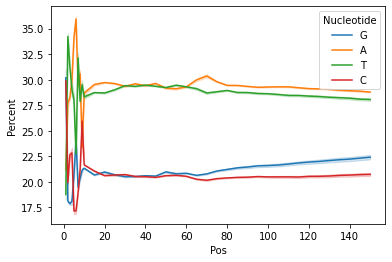

In [8]:
sns.lineplot(data=df, x='Pos', y='Percent', hue='Nucleotide')

## Read 1

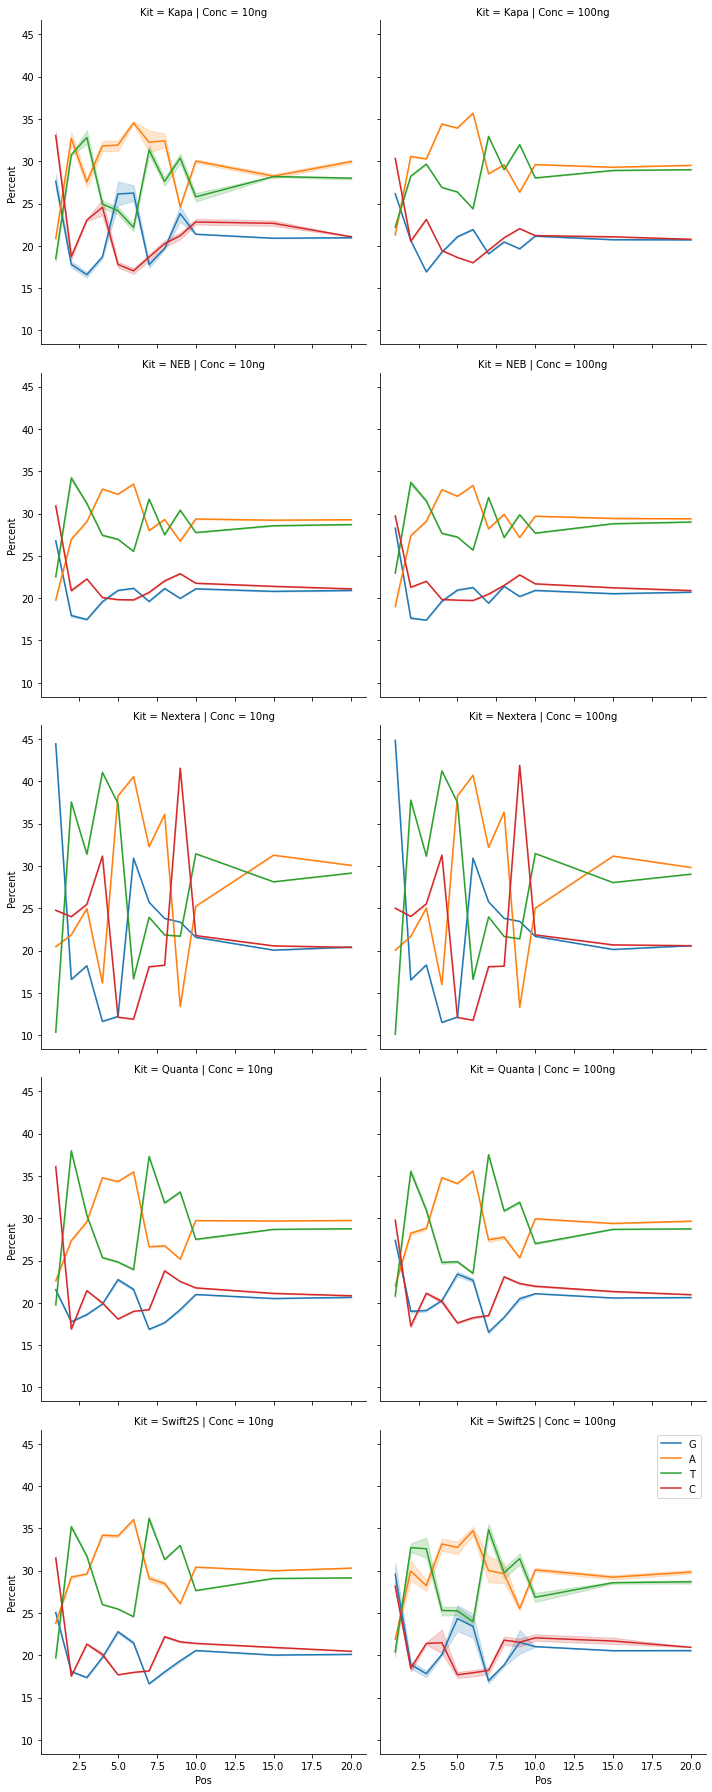

In [9]:
g = sns.FacetGrid(df[(df.Pos<21)&(df.Read==1)], col="Conc", row="Kit", hue='Nucleotide', height=5)
g.map(sns.lineplot, 'Pos', 'Percent')
plt.legend()
savefig('nucleotide_content_r1', False)

## Read 2

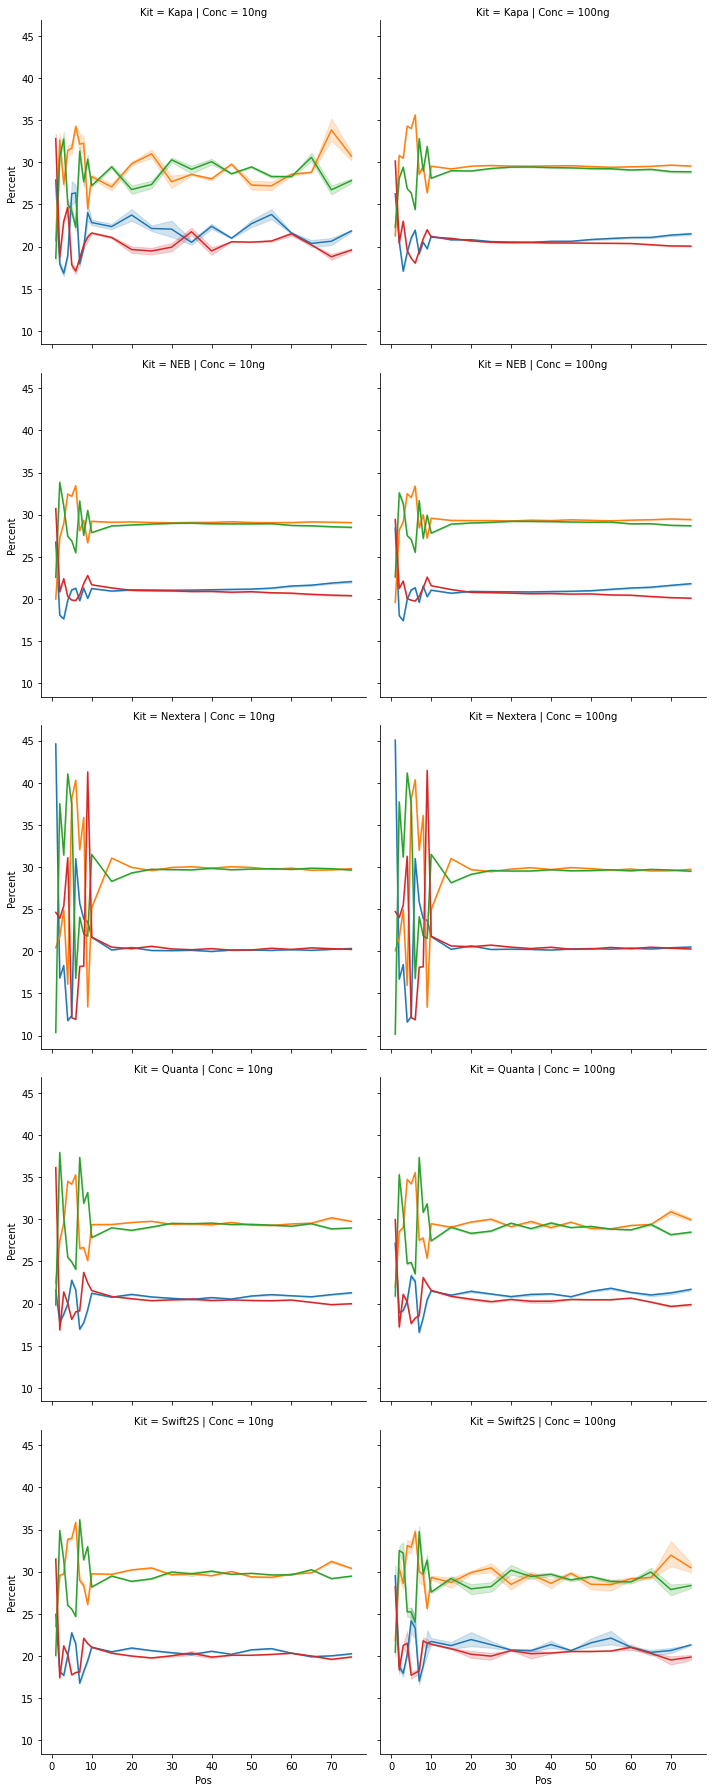

In [10]:
g = sns.FacetGrid(df[(df.Pos<80)&(df.Read==2)], col="Conc", row="Kit", hue='Nucleotide', height=5)
g.map(sns.lineplot, 'Pos', 'Percent')
savefig('nucleotide_content_r2', False)

# All in one plot

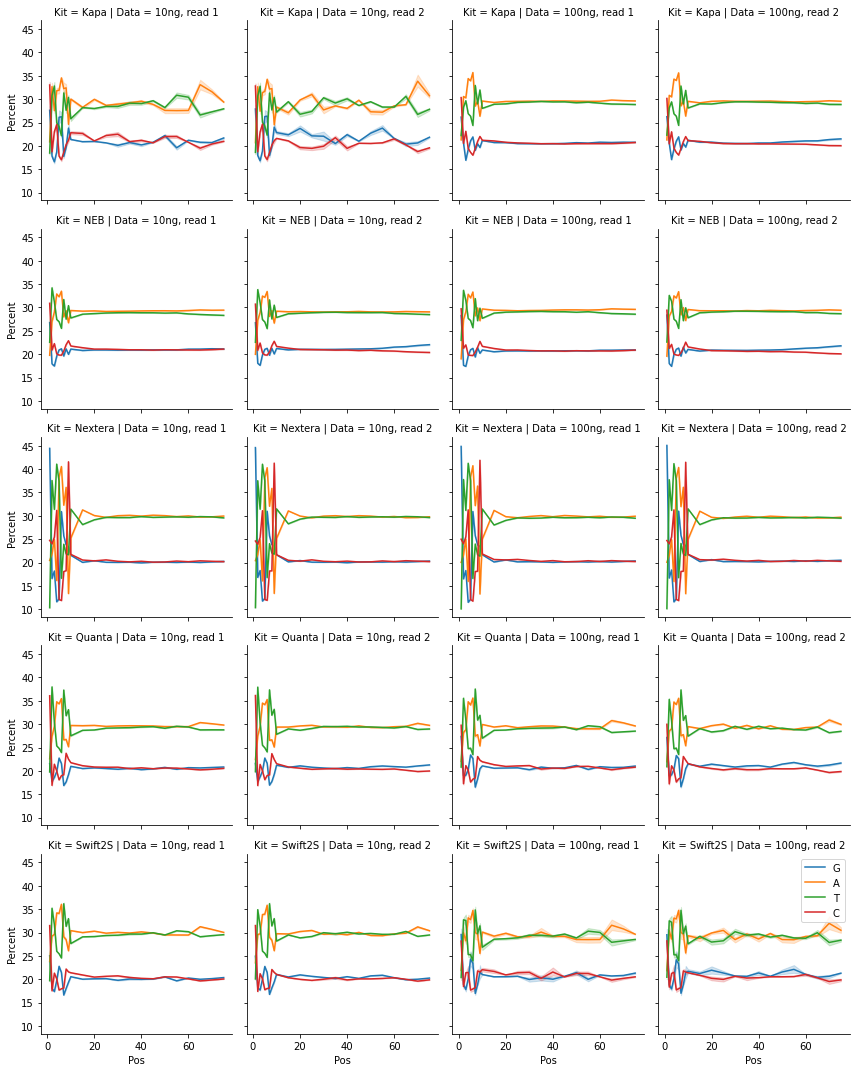

In [11]:
df['Data'] = pd.Categorical(
    df.Conc.astype(str) + ", read " + df.Read.astype(str),
    categories=['10ng, read 1', '10ng, read 2', '100ng, read 1', '100ng, read 2']
)
g = sns.FacetGrid(df[(df.Pos<80)], col="Data", row="Kit", hue='Nucleotide', height=3)
g.map(sns.lineplot, 'Pos', 'Percent')
plt.legend()
savefig('nucleotide_content_all')

# Bases 1 to N, with merged R1 and R2

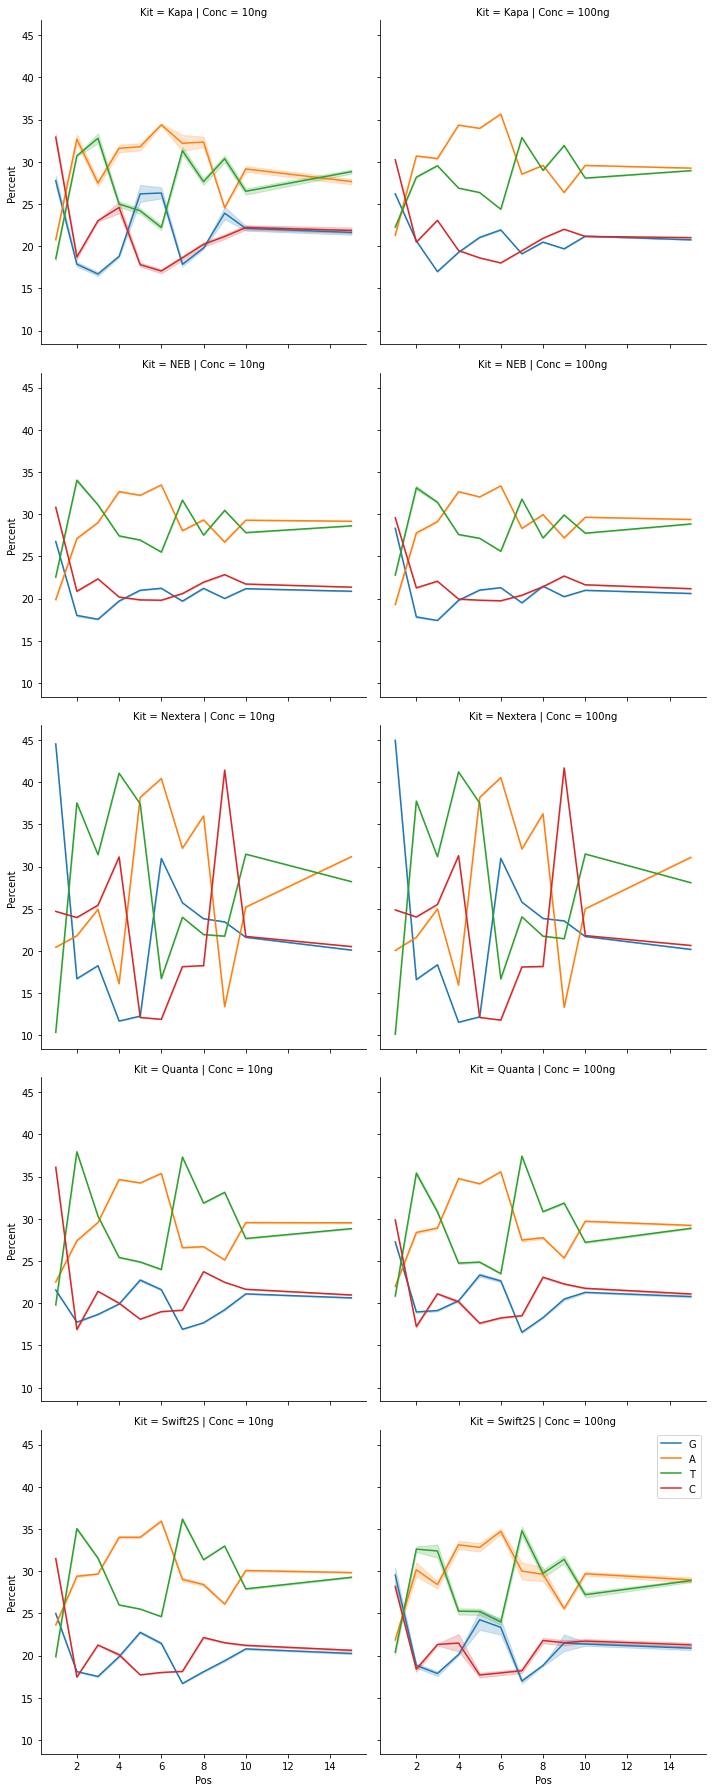

In [14]:
N = 20
g = sns.FacetGrid(df[(df.Pos<(N-1))], col="Conc", row="Kit", hue='Nucleotide', height=5)
g.map(sns.lineplot, 'Pos', 'Percent')
plt.legend()
savefig('nucleotide_content_1_to_{}'.format(N))